In [1]:
# Imports
import torch
import os
import torch.nn
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import PIL.Image as Image
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models

In [3]:
#Custom Dataset
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, feature_transforms=None, target_transform=None):
        self.image_label = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.feature_transforms = feature_transforms
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_label)

    def __getitem__(self, idx):
        path = os.path.join(self.root_dir, self.image_label.iloc[idx, 0])
        image = Image.open(path)
        label = self.image_label.iloc[idx, 1]
        if self.feature_transforms:
            image = self.feature_transforms(image)
        if self.target_transform:
            label = self.target_transform(label)
        return (image, label)

In [11]:
transform = transforms.Compose([transforms.Resize((224, 224)), transforms.ToTensor()])
load_dataset = CustomDataset('dataset.csv', 'c_d', transform)

In [12]:
dataset_size = load_dataset.__len__()
test_size = int(0.2 * dataset_size)
train_size = int(0.8*dataset_size) 
train_dataset, test_dataset = torch.utils.data.random_split(load_dataset, [train_size, test_size])

In [13]:
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=True)

In [14]:
class_names = {0:'dog', 1:'cat'} #map the label with the class name

In [15]:
# Show a batch of images
def show_image(tensor_image, title=None):
    np_image = tensor_image.numpy().transpose((1, 2, 0))
    plt.imshow(np_image)
    if title:
        plt.title(title)

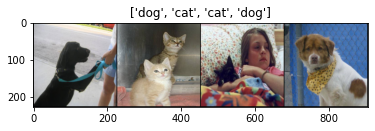

In [16]:
# Get a batch of training data
train_features, train_labels = next(iter(train_dataloader))
# Make a grid from batch
out = torchvision.utils.make_grid(train_features)

# Display image and label.
show_image(out, title=[class_names[x.item()] for x in train_labels])

In [17]:
#set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [18]:
model = models.vgg16(pretrained=True).to(device)

In [19]:
model.classifier[6].out_features = 2
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [23]:
#tran
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [24]:
def test(dataloader, model):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_function(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= size
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [25]:
epochs = 1
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_function, optimizer)
    test(test_dataloader, model)
print("Done!")

Epoch 1
-------------------------------
loss: 0.783538  [    0/   80]
loss: 1.080886  [   40/   80]
Test Error: 
 Accuracy: 50.0%, Avg loss: 0.189360 

Done!


In [35]:
#evaluate
model.eval()
train_features, train_labels = next(iter(test_dataloader))
x, y = train_features, train_labels
x, y = x.to(device), y.to(device)
with torch.no_grad():
    pred = model(x)
    predicted = class_names[pred[0].argmax(0).item()]
    actual  = class_names[y[0].item()]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')

Predicted: "cat", Actual: "cat"
